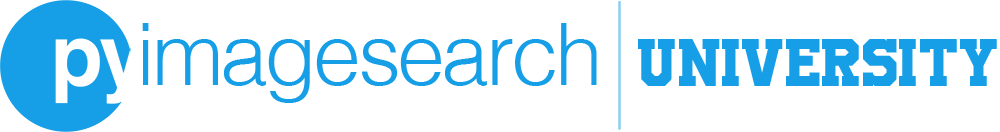

# Training and Making Predictions with Siamese Networks and Triplet Loss
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Training and Making Predictions with Siamese Networks and Triplet Loss](https://pyimg.co/avjyi) blog post published on 2023-03-20.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook.

Happy hacking!

*PyImageSearch Team*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2023 OptiReto, LLC and PyImageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
#!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/siamese-201/siamese-201.zip
#!unzip -qq siamese-201.zip
#%cd siamese-201

## Blog Post Code

### Download the dataset

In [2]:
#! wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O lfw.tgz
#! tar -zxf lfw.tgz
#! mv "lfw-deepfunneled" "train_dataset"

### Import Packages

In [4]:
# import the necessary packages
from tensorflow.keras.applications import resnet
from imutils.paths import list_images
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import random
import cv2
import os

### Building the dataset

In [5]:
train_args = {
	"dataset": "train_dataset",
	"output": "cropped_train_dataset",
}

test_args = {
	"dataset": "test_dataset",
	"output": "cropped_test_dataset",
}

args = {
	"prototxt": "face_crop_model/deploy.prototxt.txt",
	"model": "face_crop_model/res10_300x300_ssd_iter_140000.caffemodel",
	"confidence": 0.5,
}

### Load the model for corpping faces

In [6]:
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

[INFO] loading model...


### Load the model, grab files and save cropped images to disk

In [ ]:
for arguments in [train_args, test_args]:
    # check if the output dataset directory exists, if it doesn't, then
    # create it
    if not os.path.exists(arguments["output"]):
        print(f"[INFO] creating {arguments['output']}...")
        os.makedirs(arguments["output"])

    # grab the file and sub-directory names in dataset directory
    print(f"[INFO] grabbing the names of files and directories from {arguments['dataset']}...")
    names = os.listdir(arguments["dataset"])

    # loop over all names
    print("[INFO] starting to crop faces and saving them to disk...")
    for name in tqdm(names):
        # build directory path
        dirPath = os.path.join(arguments["dataset"], name)

        # check if the directory path is a directory
        if os.path.isdir(dirPath):
            # grab the path to all the images in the directory
            imagePaths = list(list_images(dirPath))

            # build the path to the output directory
            outputDir = os.path.join(arguments["output"], name)

            # check if the output directory exists, if it doesn't, then
            # create it
            if not os.path.exists(outputDir):
                os.makedirs(outputDir)

            # loop over all image paths
            for imagePath in imagePaths:
                # grab the image ID, load the image, and grab the
                # dimensions of the image
                imageID = imagePath.split(os.path.sep)[-1]
                image = cv2.imread(imagePath)
                (h, w) = image.shape[:2]

                # construct an input blob for the image by resizing to a
                # fixed 300x300 pixels and then normalizing it
                blob = cv2.dnn.blobFromImage(cv2.resize(image,
                    (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

                # pass the blob through the network and obtain the
                # detections and predictions
                net.setInput(blob)
                detections = net.forward()

                # extract the index of the detection with max
                # probability and get the maximum confidence value
                i = np.argmax(detections[0, 0, :, 2])
                confidence = detections[0, 0, i, 2]

                # filter out weak detections by ensuring the
                # `confidence` is greater than the minimum confidence
                if confidence > args["confidence"]:
                    # grab the maximum dimension value
                    maxDim = np.max(detections[0, 0, i, 3:7])

                    # check if max dimension value is greater than one,
                    # if so, skip the detection since it is erroneous
                    if maxDim > 1.0:
                        continue

                    # clip the dimension values to be between 0 and 1
                    box = np.clip(detections[0, 0, i, 3:7], 0.0, 1.0)

                    # compute the (x, y)-coordinates of the bounding
                    # box for the object
                    box = box * np.array([w, h, w, h])
                    (startX, startY, endX, endY) = box.astype("int")

                    # grab the face from the image, build the path to
                    # the output face image, and write it to disk
                    face = image[startY:endY,startX:endX,:]
                    facePath = os.path.join(outputDir, imageID)
                    cv2.imwrite(facePath, face)

    print("[INFO] finished cropping faces and saving them to disk...")

### Build the Siamese model

In [8]:
class Config:
    # path to training and testing data
    TRAIN_DATASET = "cropped_train_dataset"
    TEST_DATASET = "cropped_test_dataset"

    # model input image size
    IMAGE_SIZE = (224, 224)

    # batch size and the buffer size
    BATCH_SIZE = 256
    BUFFER_SIZE = BATCH_SIZE * 2

    # define autotune
    AUTO = tf.data.AUTOTUNE

    # define the training parameters
    LEARNING_RATE = 0.0001
    STEPS_PER_EPOCH = 50
    VALIDATION_STEPS = 10
    EPOCHS = 10

    # define the path to save the model
    OUTPUT_PATH = "output"
    MODEL_PATH = os.path.join(OUTPUT_PATH, "siamese_network")
    OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_PATH, "output_image.png")

config = Config()

### Configuration for training the model

In [9]:
class MapFunction():
	def __init__(self, imageSize):
		# define the image width and height
		self.imageSize = imageSize

	def decode_and_resize(self, imagePath):
		# read and decode the image path
		image = tf.io.read_file(imagePath)
		image = tf.image.decode_jpeg(image, channels=3)

		# convert the image data type from uint8 to float32 and then resize
		# the image to the set image size
		image = tf.image.convert_image_dtype(image, dtype=tf.float32)
		image = tf.image.resize(image, self.imageSize)

		# return the image
		return image

	def __call__(self, anchor, positive, negative):
		anchor = self.decode_and_resize(anchor)
		positive = self.decode_and_resize(positive)
		negative = self.decode_and_resize(negative)

		# return the anchor, positive and negative processed images
		return (anchor, positive, negative)

class TripletGenerator:
	def __init__(self, datasetPath):
		# create an empty list which will contain the subdirectory
		# names of the `dataset` directory with more than one image
		# in it
		self.peopleNames = list()

		# iterate over the subdirectories in the dataset directory
		for folderName in os.listdir(datasetPath):
			# build the subdirectory name
			absoluteFolderName = os.path.join(datasetPath, folderName)

			# get the number of images in the subdirectory
			numImages = len(os.listdir(absoluteFolderName))

			# if the number of images in the current subdirectory
			# is more than one, append into the `peopleNames` list
			if numImages > 1:
				self.peopleNames.append(absoluteFolderName)

		# create a dictionary of people name to thier image names
		self.allPeople = self.generate_all_people_dict()

	def generate_all_people_dict(self):
		# create an empty dictionary that will be populated with
		# directory names as keys and image names as values
		allPeople = dict()

		# iterate over all the directory names with more than one
		# image in it
		for personName in self.peopleNames:
			# get all the image names in the current directory
			imageNames = os.listdir(personName)

			# build the image paths and populate the dictionary
			personPhotos = [
				os.path.join(personName, imageName) for imageName in imageNames
			]
			allPeople[personName] = personPhotos

		# return the dictionary
		return allPeople

	def get_next_element(self):
		# create an infinite generator
		while True:
			# draw a person at random which will be our anchor and
			# positive person
			anchorName = random.choice(self.peopleNames)

			# copy the list of people names and remove the anchor
			# from the list
			temporaryNames = self.peopleNames.copy()
			temporaryNames.remove(anchorName)

			# draw a person at random from the list of people without
			# the anchor, which will act as our negative sample
			negativeName = random.choice(temporaryNames)

			# draw two images from the anchor folder without replacement
			(anchorPhoto, positivePhoto) = np.random.choice(
				a=self.allPeople[anchorName],
				size=2,
				replace=False
			)

			# draw an image from the negative folder
			negativePhoto = random.choice(self.allPeople[negativeName])

			# yield the anchor, positive and negative photos
			yield (anchorPhoto, positivePhoto, negativePhoto)

### Siamese Model

In [10]:
def get_embedding_module(imageSize):
	# construct the input layer and pass the inputs through a
	# pre-processing layer
	inputs = keras.Input(imageSize + (3,))
	x = resnet.preprocess_input(inputs)

	# fetch the pre-trained resnet 50 model and freeze the weights
	baseCnn = resnet.ResNet50(weights="imagenet", include_top=False)
	baseCnn.trainable=False

	# pass the pre-processed inputs through the base cnn and get the
	# extracted features from the inputs
	extractedFeatures = baseCnn(x)

	# pass the extracted features through a number of trainable layers
	x = layers.GlobalAveragePooling2D()(extractedFeatures)
	x = layers.Dense(units=1024, activation="relu")(x)
	x = layers.Dropout(0.2)(x)
	x = layers.BatchNormalization()(x)
	x = layers.Dense(units=512, activation="relu")(x)
	x = layers.Dropout(0.2)(x)
	x = layers.BatchNormalization()(x)
	x = layers.Dense(units=256, activation="relu")(x)
	x = layers.Dropout(0.2)(x)
	outputs = layers.Dense(units=128)(x)

	# build the embedding model and return it
	embedding = keras.Model(inputs, outputs, name="embedding")
	return embedding

def get_siamese_network(imageSize, embeddingModel):
	# build the anchor, positive and negative input layer
	anchorInput = keras.Input(name="anchor", shape=imageSize + (3,))
	positiveInput = keras.Input(name="positive", shape=imageSize + (3,))
	negativeInput = keras.Input(name="negative", shape=imageSize + (3,))

	# embed the anchor, positive and negative images
	anchorEmbedding = embeddingModel(anchorInput)
	positiveEmbedding = embeddingModel(positiveInput)
	negativeEmbedding = embeddingModel(negativeInput)

	# build the siamese network and return it
	siamese_network = keras.Model(
		inputs=[anchorInput, positiveInput, negativeInput],
		outputs=[anchorEmbedding, positiveEmbedding, negativeEmbedding]
	)
	return siamese_network

class SiameseModel(keras.Model):
	def __init__(self, siameseNetwork, margin, lossTracker):
		super().__init__()
		self.siameseNetwork = siameseNetwork
		self.margin = margin
		self.lossTracker = lossTracker

	def _compute_distance(self, inputs):
		(anchor, positive, negative) = inputs
		# embed the images using the siamese network
		embeddings = self.siameseNetwork((anchor, positive, negative))
		anchorEmbedding = embeddings[0]
		positiveEmbedding = embeddings[1]
		negativeEmbedding = embeddings[2]

		# calculate the anchor to positive and negative distance
		apDistance = tf.reduce_sum(
			tf.square(anchorEmbedding - positiveEmbedding), axis=-1
		)
		anDistance = tf.reduce_sum(
			tf.square(anchorEmbedding - negativeEmbedding), axis=-1
		)

		# return the distances
		return (apDistance, anDistance)

	def _compute_loss(self, apDistance, anDistance):
		loss = apDistance - anDistance
		loss = tf.maximum(loss + self.margin, 0.0)
		return loss

	def call(self, inputs):
		# compute the distance between the anchor and positive,
		# negative images
		(apDistance, anDistance) = self._compute_distance(inputs)
		return (apDistance, anDistance)

	def train_step(self, inputs):
		with tf.GradientTape() as tape:
			# compute the distance between the anchor and positive,
			# negative images
			(apDistance, anDistance) = self._compute_distance(inputs)

			# calculate the loss of the siamese network
			loss = self._compute_loss(apDistance, anDistance)

		# compute the gradients and optimize the model
		gradients = tape.gradient(
			loss,
			self.siameseNetwork.trainable_variables)
		self.optimizer.apply_gradients(
			zip(gradients, self.siameseNetwork.trainable_variables)
		)

		# update the metrics and return the loss
		self.lossTracker.update_state(loss)
		return {"loss": self.lossTracker.result()}

	def test_step(self, inputs):
		# compute the distance between the anchor and positive,
		# negative images
		(apDistance, anDistance) = self._compute_distance(inputs)

		# calculate the loss of the siamese network
		loss = self._compute_loss(apDistance, anDistance)

		# update the metrics and return the loss
		self.lossTracker.update_state(loss)
		return {"loss": self.lossTracker.result()}

	@property
	def metrics(self):
		return [self.lossTracker]

### Process the dataset

In [11]:
# create the data input pipeline for train and val dataset
print("[INFO] building the train and validation generators...")
trainTripletGenerator = TripletGenerator(
	datasetPath=config.TRAIN_DATASET)
valTripletGenerator = TripletGenerator(
	datasetPath=config.TRAIN_DATASET)

print("[INFO] building the train and validation `tf.data` dataset...")
trainTfDataset = tf.data.Dataset.from_generator(
	generator=trainTripletGenerator.get_next_element,
	output_signature=(
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
	)
)
valTfDataset = tf.data.Dataset.from_generator(
	generator=valTripletGenerator.get_next_element,
	output_signature=(
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
	)
)

[INFO] building the train and validation generators...
[INFO] building the train and validation `tf.data` dataset...


In [13]:
# preprocess the images
mapFunction = MapFunction(imageSize=config.IMAGE_SIZE)
print("[INFO] building the train and validation `tf.data` pipeline...")
trainDs = (trainTfDataset
    .map(mapFunction)
    .shuffle(config.BUFFER_SIZE)
    .batch(config.BATCH_SIZE)
    .prefetch(config.AUTO)
)
valDs = (valTfDataset
    .map(mapFunction)
    .batch(config.BATCH_SIZE)
    .prefetch(config.AUTO)
)

# build the embedding module and the siamese network
print("[INFO] build the siamese model...")
embeddingModule = get_embedding_module(imageSize=config.IMAGE_SIZE)
siameseNetwork =  get_siamese_network(
	imageSize=config.IMAGE_SIZE,
	embeddingModel=embeddingModule,
)
siameseModel = SiameseModel(
	siameseNetwork=siameseNetwork,
	margin=0.5,
	lossTracker=keras.metrics.Mean(name="loss"),
)

[INFO] building the train and validation `tf.data` pipeline...
[INFO] build the siamese model...
94765736/94765736 [==============================] - 8s 0us/step


### Compile and Fit the model

In [14]:
# compile the siamese model
siameseModel.compile(
	optimizer=keras.optimizers.Adam(config.LEARNING_RATE)
)

# train and validate the siamese model
print("[INFO] training the siamese model...")
siameseModel.fit(
	trainDs,
	steps_per_epoch=config.STEPS_PER_EPOCH,
	validation_data=valDs,
	validation_steps=config.VALIDATION_STEPS,
	epochs=config.EPOCHS,
)

[INFO] training the siamese model...
Epoch 1/10
50/50 [==============================] - 2318s 46s/step - loss: 0.4687 - val_loss: 0.4311
Epoch 2/10
50/50 [==============================] - 2630s 53s/step - loss: 0.4063 - val_loss: 0.3859
Epoch 3/10
50/50 [==============================] - 2832s 57s/step - loss: 0.3541 - val_loss: 0.3585
Epoch 4/10
50/50 [==============================] - 3024s 61s/step - loss: 0.3361 - val_loss: 0.3340
Epoch 5/10
50/50 [==============================] - 3406s 68s/step - loss: 0.3219 - val_loss: 0.3190
Epoch 6/10
50/50 [==============================] - 3572s 72s/step - loss: 0.3026 - val_loss: 0.2998
Epoch 7/10
50/50 [==============================] - 3676s 74s/step - loss: 0.2887 - val_loss: 0.2919
Epoch 8/10
50/50 [==============================] - 3491s 70s/step - loss: 0.2857 - val_loss: 0.2774
Epoch 9/10
50/50 [==============================] - 3519s 71s/step - loss: 0.2777 - val_loss: 0.2664
Epoch 10/10
50/50 [==============================] - 3

### Save the trained model to disk

In [15]:
# check if the output directory exists, if it doesn't, then
# create it
if not os.path.exists(config.OUTPUT_PATH):
	os.makedirs(config.OUTPUT_PATH)

# save the siamese network to disk
modelPath = config.MODEL_PATH
print(f"[INFO] saving the siamese network to {modelPath}...")
keras.models.save_model(
	model=siameseModel.siameseNetwork,
	filepath=modelPath,
    # In case we want to continue training from the last epoch
	include_optimizer=False,
)

[INFO] saving the siamese network to output\siamese_network...


INFO:tensorflow:Assets written to: output\siamese_network\assets


INFO:tensorflow:Assets written to: output\siamese_network\assets


### Infer with the trained model

[INFO] building the test generator...
[INFO] building the test `tf.data` dataset...
[INFO] loading the siamese network from output\siamese_network...


[INFO] saving the inference image to output\output_image.png...


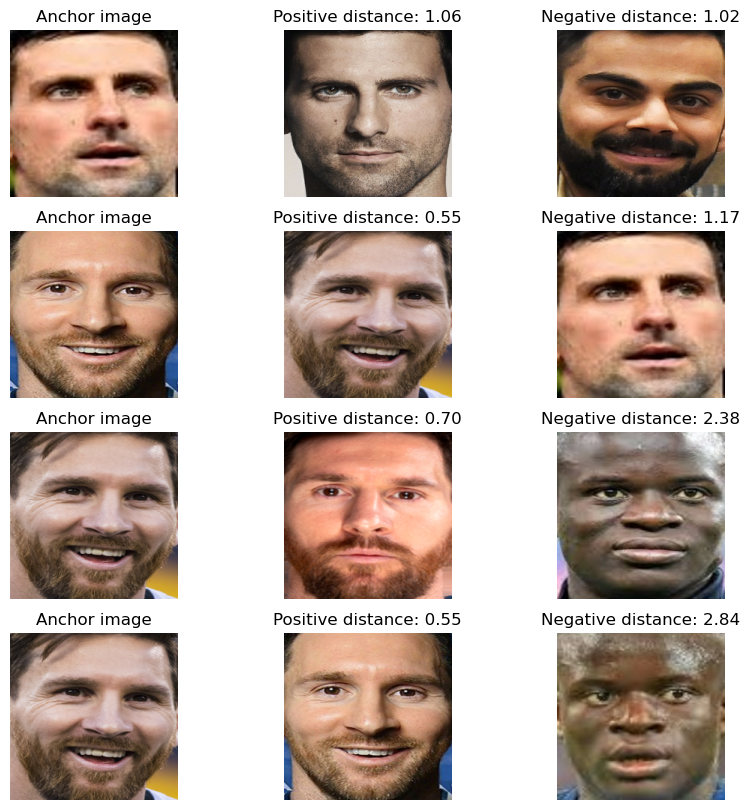

In [16]:
# create the data input pipeline for test dataset
print("[INFO] building the test generator...")
testTripletGenerator = TripletGenerator(
	datasetPath=config.TEST_DATASET)
print("[INFO] building the test `tf.data` dataset...")
testTfDataset = tf.data.Dataset.from_generator(
	generator=testTripletGenerator.get_next_element,
	output_signature=(
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
	)
)
mapFunction = MapFunction(imageSize=config.IMAGE_SIZE)
testDs = (testTfDataset
	.map(mapFunction)
	.batch(4)
	.prefetch(config.AUTO)
)

# load the siamese network from disk and build the siamese model
modelPath = config.MODEL_PATH
print(f"[INFO] loading the siamese network from {modelPath}...")
siameseNetwork = keras.models.load_model(filepath=modelPath)
siameseModel = SiameseModel(
	siameseNetwork=siameseNetwork,
	margin=0.5,
	lossTracker=keras.metrics.Mean(name="loss"),
)

# load the test data
(anchor, positive, negative) = next(iter(testDs))
(apDistance, anDistance) = siameseModel((anchor, positive, negative))
plt.figure(figsize=(10, 10))
rows = 4
for row in range(rows):
	plt.subplot(rows, 3, row * 3 + 1)
	plt.imshow(anchor[row])
	plt.axis("off")
	plt.title("Anchor image")
	plt.subplot(rows, 3, row * 3 + 2)
	plt.imshow(positive[row])
	plt.axis("off")
	plt.title(f"Positive distance: {apDistance[row]:0.2f}")
	plt.subplot(rows, 3, row * 3 + 3)
	plt.imshow(negative[row])
	plt.axis("off")
	plt.title(f"Negative distance: {anDistance[row]:0.2f}")

# check if the output directory exists, if it doesn't, then
# create it
if not os.path.exists(config.OUTPUT_PATH):
	os.makedirs(config.OUTPUT_PATH)

# save the inference image to disk
outputImagePath = config.OUTPUT_IMAGE_PATH
print(f"[INFO] saving the inference image to {outputImagePath}...")
plt.savefig(fname=outputImagePath)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Training and Making Predictions with Siamese Networks and Triplet Loss*](https://pyimg.co/avjyi) published on 2023-03-20.

# Code License Agreement
```
Copyright (c) 2023 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from OptiReto, LLC and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```